In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import sys

from datetime import datetime
import matplotlib.pyplot as pyplot
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_predict
from sklearn import ensemble
from sklearn.utils import shuffle

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [11]:
data_path = "/Users/Gabi/dev/Shareablee/twitter/data/"
user_data_path = os.path.join(data_path, 'tw_account_info')
project_path =  '/Users/Gabi/dev/Shareablee/twitter/'

os.chdir(project_path)

In [12]:
# set up column names and types to read twitter data
pd_read_names = ['index','time', 'impressions', 'retweets', 'page_id', 'twitter_id', 'followers']
pd_read_dtype = [np.str, np.str, np.int, np.int, np.str, np.int, np.int]

pd_read_names_user = ['user_id','tw_id', 'tw_name', 'cat_id', 'cat_name']
pd_read_dtype_user = [np.str, np.str, np.str, np.str, np.str]

pd_kwargs = {
    'header': 0,
    'sep': ',',
    'escapechar': '\\',
    'names': pd_read_names,
    'dtype': dict(zip(pd_read_names, pd_read_dtype)),
    'usecols': ['time', 'impressions', 'retweets', 'page_id', 'followers'],
    'parse_dates' : [0]
}

pd_user_kwargs = {
    'header': 0,
    'sep': ',',
    'escapechar': '\\',
    'names': pd_read_names_user,
    'dtype': dict(zip(pd_read_names_user, pd_read_dtype_user))
    }

In [13]:
def load_tw_data(**kwargs):
    '''
    Function to read twitter data 
    Input:
        Arguments for reading Twitter data (Twitter Data - JAN 2016)
    Output:
        Dataframe
    '''
    twitter_data = pd.read_table(twitter_data_path, **pd_kwargs)
    return twitter_data

def load_user_data(**kwargs):
    '''
    Input:
        Arguments for reading Twitter User Account Info
    Output:
        Dataframe
    '''
    user_data = pd.read_table(user_data_path, **pd_user_kwargs)
    return user_data

In [35]:
# load twitter data
twitter_data = load_tw_data()
user_data = load_user_data()

In [36]:
twitter_data.head()

,time,impressions,retweets,page_id,followers
0,2015-10-14 17:00:00,900,2,119606058,119261
1,2015-10-14 16:03:00,771,4,119606058,119261
2,2015-10-14 15:39:00,741,1,119606058,119261
3,2015-10-14 15:31:00,870,3,119606058,119261
4,2015-10-14 15:02:00,673,1,119606058,119261


In [38]:
user_data.head()

,user_id,tw_id,tw_name,cat_id,cat_name
0,30309979,16376,106andpark,3698,BET - Roll-Up - Custom
1,30309979,16376,106andpark,3955,Global* Media & Entertainment
2,30309979,16376,106andpark,1621,KCRETIRED USA - TV - Cable (9/15/14 - 9/21/14)
3,30309979,16376,106andpark,1409,KCRETIRED USA - TV - In Production
4,30309979,16376,106andpark,1477,KCRETIRED USA - TV - Scripted


In [39]:
# reorder columns
twitter_data = twitter_data[["page_id", "time" ,"followers","retweets","impressions"]]
twitter_data.head()

,page_id,time,followers,retweets,impressions
0,119606058,2015-10-14 17:00:00,119261,2,900
1,119606058,2015-10-14 16:03:00,119261,4,771
2,119606058,2015-10-14 15:39:00,119261,1,741
3,119606058,2015-10-14 15:31:00,119261,3,870
4,119606058,2015-10-14 15:02:00,119261,1,673


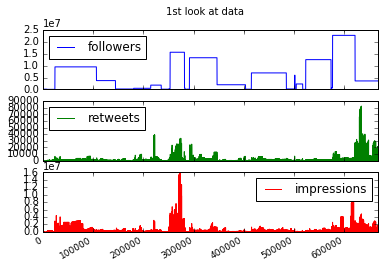

In [18]:
twitter_data[['followers','retweets','impressions',]].plot.line(subplots = True, title = '1st look at data')
pyplot.show()

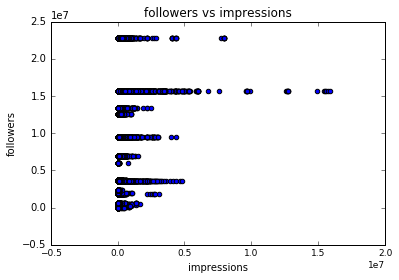

In [20]:
# plot followers vs impressions
twitter_data[['followers','impressions']].plot.scatter(x = 'followers', y = 'impressions', title = 'followers vs impressions')
pyplot.show()


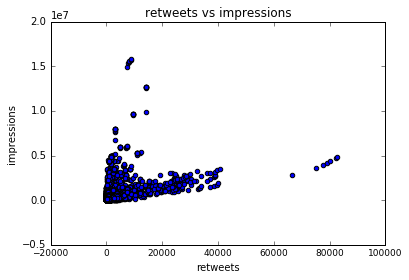

In [21]:
# plot retweets vs impressions
twitter_data[['retweets','impressions']].plot.scatter(x = 'retweets', y = 'impressions', title = 'retweets vs impressions')
pyplot.show()


In [24]:
print # filter out outlier impressions <10% and >90%

retweets_removed = len(twitter_data[(twitter_data.retweets > twitter_data.retweets.quantile(.1)) & (twitter_data.retweets < twitter_data.retweets.quantile(.9))])
impressions_removed = len(twitter_data[(twitter_data.impressions > twitter_data.impressions.quantile(.1)) & (twitter_data.impressions < twitter_data.impressions.quantile(.9))])
print "NUMBER OF OUTLIERS REMOVED:"
retweets_removed + impressions_removed


NUMBER OF OUTLIERS REMOVED:


1066159

In [40]:
# remove outliers
twitter_data = twitter_data[(twitter_data.retweets > twitter_data.retweets.quantile(.1)) & (twitter_data.retweets < twitter_data.retweets.quantile(.9))]
twitter_data = twitter_data[(twitter_data.impressions > twitter_data.impressions.quantile(.1)) & (twitter_data.impressions < twitter_data.impressions.quantile(.9))]
twitter_data.describe()
print twitter_data.quantile([.1,.25,.5,.75,.95])

       followers  retweets  impressions
0.10    201755.0       7.0       8636.0
0.25   1981815.0      14.0      20157.0
0.50   3732958.0      30.0      55213.0
0.75   9517109.0      63.0      99851.0
0.95  12569256.0     138.0     161722.8


In [41]:
# correlations: followers & impressions are more correlated
print "Post cleaning correlations"
print twitter_data[['retweets','followers','impressions']].corr()

Post cleaning correlations
             retweets  followers  impressions
retweets     1.000000   0.444137     0.554160
followers    0.444137   1.000000     0.850945
impressions  0.554160   0.850945     1.000000


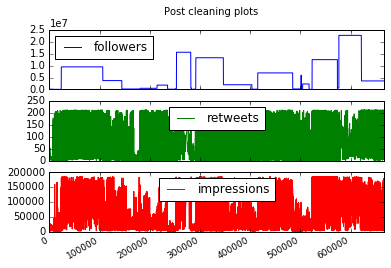

In [27]:
# quick look at data
twitter_data[['followers','retweets','impressions',]].plot.line(subplots = True, title = "Post cleaning plots")
pyplot.show()

In [43]:
# num of rows
n = twitter_data.shape[0]

# reset new index for data
twitter_index = np.arange(0, twitter_data.shape[0])
twitter_data = twitter_data.set_index(twitter_index)

# add weekday
twitter_data['weekday'] = twitter_data.time.map(lambda x: np.int(x.date().weekday()))
#twitter_data.drop('time', axis=1, inplace=True)

In [44]:
# set X and Y for modeling and cross validation
X = twitter_data[['followers','retweets']]
Y = twitter_data.impressions

# # sample for training
n_train = np.round(twitter_data.shape[0]*.90)
# randomize data
ndex_train = np.random.randint(0, n, np.int(n_train))

In [47]:
X.head()

,followers,retweets
0,119261,3
1,119261,12
2,119261,35
3,119261,4
4,119261,7


In [48]:
'''
    use followers and retweets to try and predict impressions
'''
# # training data 
x_train	 = twitter_data.ix[ndex_train]
y_train = twitter_data['impressions'][ndex_train]
x_train = x_train[["followers","retweets"]]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [50]:
# # test data
x_test = twitter_data.loc[twitter_data.ix != ndex_train]
#y_test = twitter_data['impressions'][twitter_data.ix != ndex_train]
y_test = twitter_data.loc[twitter_data.ix != ndex_train].impressions
x_test = x_test[["followers","retweets"]]

In [67]:
print "*"*30
print "FITTING SIMPLE LINEAR REGRESSION MODEL"
print "*"*30
# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
regrPred = regr.predict(x_test)
mse = mean_squared_error(regr.predict(x_test), y_test)

# # The coefficients
print 'Coefficients: \n', regr.coef_
print "Mean Squared Error: %.2f" % np.mean((regr.predict(x_test) - y_test) ** 2)
# Explained variance score: 1 is perfect prediction (R^2 of prediction)
print'Explained Variance score (R-squared): %.4f' % regr.score(x_test, y_test)
rsquared_regr = r2_score(y_test, regrPred)

******************************
FITTING SIMPLE LINEAR REGRESSION MODEL
******************************
Coefficients: 
[  8.92861792e-03   2.57785575e+02]
Mean Squared Error: 487079614.01
Explained Variance score (R-squared): 0.8048


In [84]:
print "*"*30
print "RIDGE REGRESSION"
print "*"*30
# RIDGE REGRESSION
ridgeModel = Ridge(alpha = 0.1)
ridgeModel.fit(x_train, y_train)
ridgePred = ridgeModel.predict(x_test)
rsquared_ridge = r2_score(y_test, ridgePred)
# # The coefficients
print 'Coefficients: \n', ridgeModel.coef_
print "Residual sum of squares: %.2f" % np.mean((ridgePred - y_test) ** 2)
# Explained variance score: 1 is perfect prediction
print 'Variance score: %.4f' % ridgeModel.score(x_test, y_test)


******************************
RIDGE REGRESSION
******************************
Coefficients: 
[  8.92861792e-03   2.57785575e+02]
Residual sum of squares: 487079614.00
Variance score: 0.8048


******************************
CROSS VALIDATION/K-FOLD FOR LASSO REGRESSION
******************************


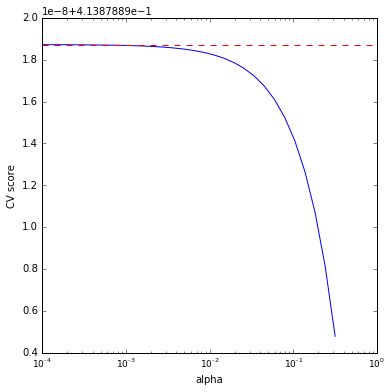

In [55]:
print "*"*30
print "CROSS VALIDATION/K-FOLD FOR LASSO REGRESSION"
print "*"*30

lassoModel = linear_model.Lasso()
alphas = np.logspace(-4, -.5, 30)
scores = list()
scores_std = list()
for alpha in alphas:
    lassoModel.alpha = alpha
    this_scores = cross_validation.cross_val_score(estimator = lassoModel, X=X, y=Y, n_jobs=1, cv=5)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

pyplot.figure(figsize=(6, 6))
pyplot.semilogx(alphas, scores)
pyplot.ylabel('CV score')
pyplot.xlabel('alpha')
pyplot.axhline(np.max(scores), linestyle='--', color='red')
pyplot.show()


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


[fold 0] alpha: 0.000100000, score: 0.74724
[fold 1] alpha: 0.000132035, score: 0.75839
[fold 2] alpha: 0.000174333, score: 0.76074
[fold 3] alpha: 0.000230181, score: 0.74466
[fold 4] alpha: 0.000303920, score: 0.76616
[fold 5] alpha: 0.000401281, score: 0.76317
[fold 6] alpha: 0.000529832, score: 0.75913
[fold 7] alpha: 0.000699564, score: 0.74823
[fold 8] alpha: 0.000923671, score: 0.76466
[fold 9] alpha: 0.001219570, score: 0.77360
[fold 10] alpha: 0.001610262, score: 0.76597
[fold 11] alpha: 0.002126112, score: 0.76835
[fold 12] alpha: 0.002807216, score: 0.75443
[fold 13] alpha: 0.003706513, score: 0.77491
[fold 14] alpha: 0.004893901, score: 0.76271
[fold 15] alpha: 0.006461671, score: 0.76570
[fold 16] alpha: 0.008531679, score: 0.76340
[fold 17] alpha: 0.011264817, score: 0.76113
[fold 18] alpha: 0.014873521, score: 0.76592
[fold 19] alpha: 0.019638280, score: 0.74932
[fold 20] alpha: 0.025929438, score: 0.75301
[fold 21] alpha: 0.034235980, score: 0.75856
[fold 22] alpha: 0.0

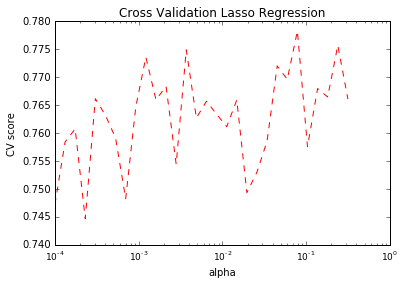

Best alpha's
       alpha  fold     score
24  0.078805    24  0.778290
28  0.239503    28  0.775724
13  0.003707    13  0.774912
9   0.001220     9  0.773601
22  0.045204    22  0.772028
23  0.059685    23  0.769621
11  0.002126    11  0.768349
26  0.137382    26  0.767980
27  0.181393    27  0.766462
4   0.000304     4  0.766156


In [56]:
lasso_cv = linear_model.LassoCV(alphas=alphas, cv=5, selection='random')
folds = 30
k_fold = cross_validation.KFold(n=len(X), n_folds=folds, shuffle=True)
cv_scores = list()
cv_alphas = list()
for k, (train, test) in enumerate(k_fold):
    lasso_cv.fit(X.ix[train], Y.ix[train])
    lasso_cv.alpha_ = alphas[k]
    cv_alphas.append(lasso_cv.alpha_)
    cv_scores.append(lasso_cv.score(X.ix[test], Y.ix[test]))
    print(
    "[fold {0}] alpha: {1:.9f}, score: {2:.5f}".format(k, lasso_cv.alpha_, lasso_cv.score(X.ix[test], Y.ix[test])))
# put results in dataframe
lasso_cv_df = pd.DataFrame({'fold': range(folds), 'alpha': cv_alphas, 'score': cv_scores})
# plot lasso cv results
pyplot.figure()
pyplot.semilogx(x = cv_alphas, y = cv_scores, 'r--')
pyplot.ylabel('CV score')
pyplot.xlabel('alpha')
pyplot.title('Cross Validation Lasso Regression')
pyplot.show()

# best alpha
print "Best alpha's\n", lasso_cv_df.sort_values('score', ascending=False).head(10)
best_alpha = lasso_cv_df.sort_values('score', ascending=False).alpha.iloc[0]

In [85]:
# fit model using best alpha
lassoModel = linear_model.Lasso(alpha=best_alpha)
lassoModel.fit(x_train, y_train)
lassoPred = lassoModel.predict(x_test)
# # The coefficients
print 'Coefficients:', lassoModel.coef_
print("Residual sum of squares: %.2f" % np.mean((lassoPred - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('R-Squared score on training: %.3f' % lassoModel.score(x_train, y_train))
print('R-Squared score on test: %.3f' % lassoModel.score(x_test, y_test))
r2_score(lassoPred, y_test)
rsquared_lasso=r2_score(lassoPred, y_test)



Coefficients: [  8.92861816e-03   2.57785521e+02]
Residual sum of squares: 487079607.55
R-Squared score on training: 0.764
R-Squared score on test: 0.805


In [9]:
err_threshold = 0.6
model_err_stats = linModel1.model_results.groupby(['page_id','tw_name'])['perc_diff'].agg(['count','sum','mean']).sort_values('mean',ascending = False, axis =0).reset_index()
model_err_stats.rename(columns = {'count':'frequency', 'sum':'err_sum' ,'mean':'err_mean'}, inplace = True)
tw_names_drop = model_err_stats[model_err_stats.err_mean > err_threshold][['page_id','tw_name']].drop_duplicates()

print "MODEL 1 RESULTS:"
print model_err_stats
print
print "BIGGEST ERRORS:"
print tw_names_drop


MODEL 1 RESULTS:
       page_id          tw_name  frequency       err_sum   err_mean
0       759251              CNN        368   4224.313661  11.479113
1     19426551              nfl        128   1093.625240   8.543947
2      2367911              MTV       5687  16611.497946   2.920960
3     30309979       106andpark        321    593.720500   1.849597
4     16560657              bet       8061   8792.894752   1.090795
5     14934818          InStyle      15076  13823.453381   0.916918
6     32448740        brueggers         54     48.385489   0.896028
7    634784951      dasaniwater          1      0.812673   0.812673
8     27677483       essencemag       5825   4621.878001   0.793455
9     18342955       abc11_wtvd       4109   3127.868601   0.761224
10  1426645165           bustle       3860   2510.785230   0.650462
11    25453312  hallmarkchannel       2534   1608.644252   0.634824
12   223525053     ringlingbros         28     15.788833   0.563887
13     5988062     theeconomist